# Monthly Cross-Section: Estimation

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm
import arch as am

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Data

In [6]:
industries_monthly = pd.read_pickle('df_industries_monthly.pkl')
#industries_daily = pd.read_pickle('df_industries_daily.pkl')

## Estimation
### Setup

In [7]:
df_xs_estimates = pd.DataFrame(industries_monthly.stack().rename(('data','return')))

In [8]:
#df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')

### Define outputs

In [9]:
def get_moment_vector(y):
    '''
    This function defines a vector that contains the first four moments of y
    '''
    moment_vector = \
        pd.Series([y.mean(), y.std(), y.var(), y.skew(),y.kurtosis()], index=['mean','std','var','skew','exkurt'])
    return moment_vector

In [10]:
def get_hmm_model_output(hmm_model): # TO DO: function is broken for k>2, transition probabilities wrong
    '''
    This function defines a vector with estimates from a hidden markov model object
    '''
    #sort by volatility
    sorted_indices = hmm_model.params.loc[[i[0:6]=='sigma2' for i in hmm_model.params.index]].sort_values().index
    sort_k = [int(i[7]) for i in sorted_indices]
    k = len(sort_k)
    n = int(len(hmm_model.params)/k)
    list_1 = [i*n for i in range(n) for j in range(n)]
    list_2 = sort_k*n
    sort_params = [i+j for i,j in zip(list_1,list_2)]
    
    model_output = \
        pd.Series([hmm_model.mle_retvals['converged'],algo,hmm_model.nobs,hmm_model.aic,hmm_model.bic,hmm_model.llf],index=['convergence','algorithm','T','aic','bic','likelihood'])\
            .append(pd.Series(hmm_model.params.values[sort_params],index=['p00','p10','mu_0','mu_1','sigma2_0','sigma2_1']))\
            .append(pd.Series(hmm_model.bse.values[sort_params],index=['p00_se','p10_se','mu_0_se','mu_1_se','sigma2_0_se','sigma2_1_se']))\
            .append(pd.Series(hmm_model.cov_params().loc['const[0]','const[1]'],index=['mu_cov']))\
            .append(pd.Series(hmm_model.cov_params().loc['sigma2[0]','sigma2[1]'],index=['sigma_cov']))\
            .append(pd.Series(hmm_model.cov_params().loc['p[0->0]','p[1->0]'],index=['prob_cov']))\
            .append(pd.Series(hmm_model.smoothed_marginal_probabilities.iloc[-1,:].values[sort_k],index=['smooth_prob_0','smooth_prob_1']))\
            .append(pd.Series(hmm_model.filtered_marginal_probabilities.iloc[-1,:].values[sort_k],index=['filt_prob_0','filt_prob_1']))\
            .append(pd.Series(hmm_model.smoothed_marginal_probabilities.mean().values[sort_k],index=['mean_smooth_prob_0','mean_smooth_prob_1']))\
            .append(pd.Series(hmm_model.filtered_marginal_probabilities.mean().values[sort_k],index=['mean_filt_prob_0','mean_filt_prob_1']))\
            .append(pd.Series(abs(hmm_model.smoothed_marginal_probabilities.iloc[-1,:]-hmm_model.smoothed_marginal_probabilities.iloc[-2,:]).mean(),index=['smooth_prob_innov']))\
            .append(pd.Series(abs(hmm_model.filtered_marginal_probabilities.iloc[-1,:]-hmm_model.filtered_marginal_probabilities.iloc[-2,:]).mean(),index=['filt_prob_innov']))
    return model_output

In [11]:
def get_hmm_model_output(hmm_model): # TO DO: Make suitable for more states
    '''
    This function defines a vector with estimates from a hidden markov model object
    '''
    model_output = \
        pd.Series([hmm_model.mle_retvals['converged'],algo,hmm_model.nobs,hmm_model.aic,hmm_model.bic,hmm_model.llf],index=['convergence','algorithm','T','aic','bic','likelihood'])\
            .append(pd.Series(hmm_model.params.values,index=['p00','p10','mu_0','mu_1','sigma2_0','sigma2_1']))\
            .append(pd.Series(hmm_model.bse.values,index=['p00_se','p10_se','mu_0_se','mu_1_se','sigma2_0_se','sigma2_1_se']))\
            .append(pd.Series(hmm_model.cov_params().loc['const[0]','const[1]'],index=['mu_cov']))\
            .append(pd.Series(hmm_model.cov_params().loc['sigma2[0]','sigma2[1]'],index=['sigma_cov']))\
            .append(pd.Series(hmm_model.cov_params().loc['p[0->0]','p[1->0]'],index=['prob_cov']))\
            .append(pd.Series(hmm_model.smoothed_marginal_probabilities.iloc[-1,:].values,index=['smooth_prob_0','smooth_prob_1']))\
            .append(pd.Series(hmm_model.filtered_marginal_probabilities.iloc[-1,:].values,index=['filt_prob_0','filt_prob_1']))\
            .append(pd.Series(hmm_model.smoothed_marginal_probabilities.mean().values,index=['mean_smooth_prob_0','mean_smooth_prob_1']))\
            .append(pd.Series(hmm_model.filtered_marginal_probabilities.mean().values,index=['mean_filt_prob_0','mean_filt_prob_1']))\
            .append(pd.Series(abs(hmm_model.smoothed_marginal_probabilities.iloc[-1,:]-hmm_model.smoothed_marginal_probabilities.iloc[-2,:]).mean(),index=['smooth_prob_innov']))\
            .append(pd.Series(abs(hmm_model.filtered_marginal_probabilities.iloc[-1,:]-hmm_model.filtered_marginal_probabilities.iloc[-2,:]).mean(),index=['filt_prob_innov']))
    return model_output

In [12]:
def get_state_probabilities(hmm_model):
    '''
    This is to extract the in-sample state probabilities
    '''
    state_probs = \
        pd.DataFrame(hmm_model.smoothed_marginal_probabilities.values, index=hmm_model.smoothed_marginal_probabilities.index, columns=['smooth_is_0','smooth_is_1'])\
            .join(pd.DataFrame(hmm_model.filtered_marginal_probabilities.values, index=hmm_model.smoothed_marginal_probabilities.index, columns=['filt_is_0','filt_is_1']))
    return state_probs

### Full Sample
#### Names

In [13]:
hmm_name = 'HMM_full'
moment_name = 'moment_full'

In [14]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [15]:
%%time
count = 0
full_sample_estimates = pd.DataFrame([])

for name,data in tqdm.tqdm(industries_monthly.items()):
    
    # calculate sample moments
    moment_vector = get_moment_vector(data)
    
    # treat outliers
    y = pd.Series(data.values,index=data.index).copy()
    m,s = moment_vector[['mean','std']]
    y[y<m-2.325*s] = m-2.325*s + 0.1*(y[y<m-2.325*s]-(m-2.325*s))
    y[y>m+2.325*s] = m+2.325*s + 0.1*(y[y>m-2.325*s]-(m+2.325*s))
    #y = calc.shrink_outliers(y,alpha=1.96,lamb=1)
    
    # set initial guesses for parameters
    init = [0.9,0.1] + [m] + [m] + [(2*s)**2] + [(0.5*s)**2]
    
    # estimate model
    for algo in algos:
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore")
            hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False, search_reps=20)
        if (not any(hmm_model.params.isna())):
            break
            
    # outputs
    model_output = get_hmm_model_output(hmm_model)
    state_probs = get_state_probabilities(hmm_model)
    
    # safe estimates
    if count == 0 & False:
        df_xs_estimates = df_xs_estimates\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))\
            .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], state_probs.columns]), index=df_xs_estimates.index))
        
    full_sample_estimates = full_sample_estimates.join(model_output.rename(name),how='outer')
    
    selected_rows = \
        (df_xs_estimates.index.get_level_values('Industry')==name)\
        &np.array([x in state_probs.index for x in df_xs_estimates.index.get_level_values('Date')])
    df_xs_estimates.loc[selected_rows,(moment_name,moment_vector.index)] = moment_vector.values
    df_xs_estimates.loc[selected_rows,(hmm_name,model_output.index)] = model_output.values
    df_xs_estimates.loc[selected_rows,(hmm_name,state_probs.columns)] = state_probs.values
    
    count += 1
    
df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

49it [01:13,  1.41s/it]


Wall time: 1min 13s


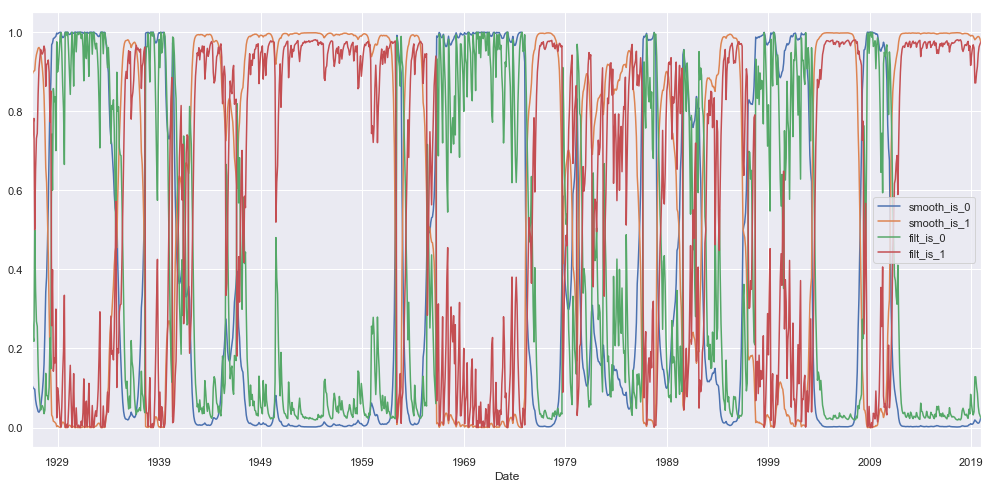

In [20]:
get_state_probabilities(hmm_model).plot(figsize=[17,8])

### Expanding Window
#### Names

In [16]:
win_yrs = 20 #length of first window

In [17]:
hmm_name = 'HMM_expand'
moment_name = 'moment_expand'

In [18]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [19]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')

In [21]:
%%time
start = 0
count = start

for name,data in industries_monthly.iloc[:,start:].items():
    
    # find dates to optimise
    data = data[data.notna()]
    opt_dates = data.index[data.index>data.index[0].replace(year=data.index[0].year+win_yrs)]
    
    correction_count = 0
    switch_count = 0
    for iDate in tqdm.tqdm(opt_dates):
        
        # select data
        select_window = data.index[data.index<=iDate]
        y = data.loc[select_window].copy()
        
        # calculate sample moments
        moment_vector = get_moment_vector(y)
        
        # treat outliers
        y = calc.shrink_outliers(y, alpha=1.645, lamb=1)
        
        # set initial guesses for parameters
        m,s = y.mean(),y.std()
        win_init = [0.9,0.1] + [m] + [m] + [(2*s)**2] + [(0.5*s)**2]
        
        if iDate == opt_dates[0]:
            init = win_init
        else:
            if  all(hmm_model.params.notna()):
                init = hmm_model.params.values
            else:
                init = win_init
            
            # move initial transition probabilities to reasonable levels
            if (min(init[0],1-init[0])<0.01) | (min(init[1],1-init[1])<0.01):
                init = 0.9*init + 0.1*np.asarray(win_init)
                correction_count += 1
        
        # estimate model
        for algo in algos:
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False)
            if (not any(hmm_model.params.isna())):
                break
                
        if hmm_model.params[4] < hmm_model.params[5]:
            switch_count += 1
        
        # outputs
        model_output = get_hmm_model_output(hmm_model)
        
        # safe estimates
        if (count == 0) & (iDate == opt_dates[0]) & True:
            df_xs_estimates = df_xs_estimates\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))

        df_xs_estimates.loc[(iDate,name),(moment_name,moment_vector.index)] = moment_vector.values
        df_xs_estimates.loc[(iDate,name),(hmm_name,model_output.index)] = model_output.values
        
    count += 1
    print(name, ':', list(industries_monthly.columns).index(name)+1, '/', len(industries_monthly.columns), ',', correction_count, 'corrections, ', switch_count,'switches')
    
    df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:31<00:00,  2.58it/s]


Agric : 1 / 49 , 547 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:14<00:00,  1.65it/s]


Food  : 2 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [02:24<00:00,  2.36it/s]


Soda  : 3 / 49 , 77 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:44<00:00,  2.48it/s]


Beer  : 4 / 49 , 271 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:09<00:00,  2.67it/s]


Smoke : 5 / 49 , 5 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:38<00:00,  2.38it/s]


Toys  : 6 / 49 , 458 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [04:49<00:00,  2.54it/s]


Fun   : 7 / 49 , 27 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [04:42<00:00,  2.53it/s]


Books : 8 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [04:59<00:00,  2.44it/s]


Hshld : 9 / 49 , 65 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:39<00:00,  2.06it/s]


Clths : 10 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [02:36<00:00,  2.64it/s]


Hlth  : 11 / 49 , 254 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:45<00:00,  2.43it/s]


MedEq : 12 / 49 , 604 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [04:48<00:00,  2.60it/s]


Drugs : 13 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [04:53<00:00,  2.61it/s]


Chems : 14 / 49 , 674 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 833/833 [05:13<00:00,  2.55it/s]


Rubbr : 15 / 49 , 430 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:21<00:00,  2.38it/s]


Txtls : 16 / 49 , 497 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:17<00:00,  2.66it/s]


BldMt : 17 / 49 , 486 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [06:33<00:00,  2.51it/s]


Cnstr : 18 / 49 , 770 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:28<00:00,  2.05it/s]


Steel : 19 / 49 , 816 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [02:29<00:00,  2.70it/s]


FabPr : 20 / 49 , 1 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:10<00:00,  2.43it/s]


Mach  : 21 / 49 , 566 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:15<00:00,  2.29it/s]


ElcEq : 22 / 49 , 791 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:02<00:00,  2.47it/s]


Autos : 23 / 49 , 488 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [07:11<00:00,  2.38it/s]


Aero  : 24 / 49 , 792 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:39<00:00,  2.59it/s]


Ships : 25 / 49 , 456 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [02:35<00:00,  3.18it/s]


Guns  : 26 / 49 , 191 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 437/437 [02:17<00:00,  3.17it/s]


Gold  : 27 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:16<00:00,  2.44it/s]


Mines : 28 / 49 , 300 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [06:27<00:00,  1.79it/s]


Coal  : 29 / 49 , 258 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [06:35<00:00,  2.58it/s]


Oil   : 30 / 49 , 221 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:41<00:00,  2.51it/s]


Util  : 31 / 49 , 851 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:18<00:00,  2.41it/s]


Telcm : 32 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 869/869 [05:20<00:00,  2.31it/s]


PerSv : 33 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [04:55<00:00,  2.54it/s]


BusSv : 34 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:09<00:00,  2.52it/s]


Hardw : 35 / 49 , 117 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 413/413 [02:43<00:00,  3.15it/s]


Softw : 36 / 49 , 178 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:20<00:00,  2.36it/s]


Chips : 37 / 49 , 724 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:13<00:00,  2.51it/s]


LabEq : 38 / 49 , 88 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 845/845 [07:41<00:00,  2.37it/s]


Paper : 39 / 49 , 725 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:23<00:00,  2.48it/s]


Boxes : 40 / 49 , 378 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:37<00:00,  2.40it/s]


Trans : 41 / 49 , 316 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [06:06<00:00,  2.34it/s]


Whlsl : 42 / 49 , 164 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:24<00:00,  2.28it/s]


Rtail : 43 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:21<00:00,  2.27it/s]


Meals : 44 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:09<00:00,  2.40it/s]


Banks : 45 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:17<00:00,  2.56it/s]


Insur : 46 / 49 , 325 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:13<00:00,  2.49it/s]


RlEst : 47 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:12<00:00,  2.63it/s]


Fin   : 48 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 881/881 [05:16<00:00,  1.66it/s]


Other : 49 / 49 , 79 corrections,  0 switches
Wall time: 4h 11min 57s


### Rolling Window
#### Names

In [22]:
win_yrs = 40

In [23]:
hmm_name = 'HMM_roll_'+str(win_yrs)
moment_name = 'moment_roll_'+str(win_yrs)

In [24]:
algos = ['powell','ncg','bfgs','cg','newton']

#### Run

In [25]:
df_xs_estimates = pd.read_pickle('df_xs_estimates_monthly.pkl')

In [27]:
start = 0
#end = -1

In [17]:
%%time
count = start

for name,data in industries_monthly.iloc[:,start:].items():
    
    # find dates to optimise
    data = data[data.notna()]
    opt_dates = data.index[data.index>data.index[0].replace(year=data.index[0].year+win_yrs)]
    
    correction_count = 0
    switch_count = 0
    for iDate in tqdm.tqdm(opt_dates):
        
        # select data
        select_window = data.index[(data.index>[iDate+dt.timedelta(1) if (iDate.day==29)&(iDate.month==2) else iDate][0].replace(year=iDate.year-win_yrs)) & (data.index<=iDate)]
        y = data.loc[select_window].copy()
        
        # calculate sample moments
        moment_vector = get_moment_vector(y)
        
        # treat outliers
        y = calc.shrink_outliers(y, alpha=1.645, lamb=1)
        
        #m,s = moment_vector[['mean','std']]
        #y.loc[y<m-1.96*s] = m-1.96*s + 0.1*(y[y<m-1.96*s]-(m-1.96*s))
        #y.loc[y>m+1.96*s] = m+1.96*s + 0.1*(y[y>m-1.96*s]-(m+1.96*s))
        
        # set initial guesses for parameters
        m,s = y.mean(),y.std()
        win_init = [0.9,0.1] + [m] + [m] + [(2*s)**2] + [(0.5*s)**2]
        
        if iDate == opt_dates[0]:
            init = win_init
        else:
            if  all(hmm_model.params.notna()):
                init = hmm_model.params.values
            else:
                init = win_init
            
            # move initial transition probabilities to reasonable levels
            if (min(init[0],1-init[0])<0.01) | (min(init[1],1-init[1])<0.01):
                init = 0.9*init + 0.1*np.asarray(win_init)
                correction_count += 1
        
        # estimate model
        for algo in algos:
            with warnings.catch_warnings():
                warnings.filterwarnings(action="ignore")
                hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=init, method=algo, disp=False)
            if all(hmm_model.params.notna()):
                break
                
        if hmm_model.params[4] < hmm_model.params[5]:
            switch_count += 1
        
        # outputs
        model_output = get_hmm_model_output(hmm_model)
        
        # safe estimates
        if (count == 0) & (iDate == opt_dates[0]) & True:
            df_xs_estimates = df_xs_estimates\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[moment_name], moment_vector.index]), index=df_xs_estimates.index))\
                .join(pd.DataFrame(np.nan, columns=pd.MultiIndex.from_product([[hmm_name], model_output.index]), index=df_xs_estimates.index))

        df_xs_estimates.loc[(iDate,name),(moment_name,moment_vector.index)] = moment_vector.values
        df_xs_estimates.loc[(iDate,name),(hmm_name,model_output.index)] = model_output.values
        
    count += 1
    print(name, ':', list(industries_monthly.columns).index(name)+1, '/', len(industries_monthly.columns), ',', correction_count, 'corrections, ', switch_count,'switches')
    
    df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:31<00:00,  2.86it/s]


Food  : 2 / 49 , 18 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [01:09<00:00,  2.82it/s]


Soda  : 3 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:26<00:00,  2.85it/s]


Beer  : 4 / 49 , 9 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:51<00:00,  2.73it/s]


Smoke : 5 / 49 , 63 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:10<00:00,  2.40it/s]


Toys  : 6 / 49 , 155 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:50<00:00,  2.70it/s]


Fun   : 7 / 49 , 27 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:53<00:00,  2.78it/s]


Books : 8 / 49 , 201 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:51<00:00,  2.71it/s]


Hshld : 9 / 49 , 46 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:05<00:00,  2.23it/s]


Clths : 10 / 49 , 105 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:56<00:00,  2.81it/s]


Hlth  : 11 / 49 , 80 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:42<00:00,  2.76it/s]


MedEq : 12 / 49 , 13 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:42<00:00,  2.48it/s]


Drugs : 13 / 49 , 21 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:49<00:00,  2.96it/s]


Chems : 14 / 49 , 123 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:34<00:00,  2.80it/s]


Rubbr : 15 / 49 , 12 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:50<00:00,  1.16it/s]


Txtls : 16 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:49<00:00,  2.83it/s]


BldMt : 17 / 49 , 82 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:37<00:00,  2.96it/s]


Cnstr : 18 / 49 , 146 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:53<00:00,  2.79it/s]


Steel : 19 / 49 , 142 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [01:19<00:00,  2.60it/s]


FabPr : 20 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:56<00:00,  2.06it/s]


Mach  : 21 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:44<00:00,  2.74it/s]


ElcEq : 22 / 49 , 96 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:55<00:00,  2.46it/s]


Autos : 23 / 49 , 0 corrections,  254 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:36<00:00,  2.16it/s]


Aero  : 24 / 49 , 48 corrections,  307 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:00<00:00,  2.05it/s]


Ships : 25 / 49 , 10 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [01:32<00:00,  2.48it/s]


Guns  : 26 / 49 , 24 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [01:22<00:00,  2.40it/s]


Gold  : 27 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:19<00:00,  2.85it/s]


Mines : 28 / 49 , 56 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:22<00:00,  2.13it/s]


Coal  : 29 / 49 , 285 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:29<00:00,  2.94it/s]


Oil   : 30 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:31<00:00,  2.38it/s]


Util  : 31 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:46<00:00,  2.82it/s]


Telcm : 32 / 49 , 56 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:34<00:00,  3.01it/s]


PerSv : 33 / 49 , 4 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:33<00:00,  2.55it/s]


BusSv : 34 / 49 , 285 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:51<00:00,  1.36it/s]


Hardw : 35 / 49 , 145 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [01:30<00:00,  1.80it/s]


Softw : 36 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:29<00:00,  1.85it/s]


Chips : 37 / 49 , 0 corrections,  263 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:56<00:00,  2.87it/s]


LabEq : 38 / 49 , 128 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [03:14<00:00,  1.58it/s]


Paper : 39 / 49 , 257 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:44<00:00,  2.79it/s]


Boxes : 40 / 49 , 21 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:23<00:00,  2.89it/s]


Trans : 41 / 49 , 20 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:26<00:00,  2.85it/s]


Whlsl : 42 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:45<00:00,  2.94it/s]


Rtail : 43 / 49 , 127 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:15<00:00,  3.43it/s]


Meals : 44 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:17<00:00,  3.30it/s]


Banks : 45 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:18<00:00,  3.25it/s]


Insur : 46 / 49 , 15 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:17<00:00,  2.71it/s]


RlEst : 47 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:15<00:00,  3.44it/s]


Fin   : 48 / 49 , 0 corrections,  0 switches


100%|████████████████████████████████████████████████████████████████████████████████| 419/419 [02:19<00:00,  2.46it/s]


Other : 49 / 49 , 114 corrections,  0 switches
Wall time: 2h 5min 48s


In [26]:
df_xs_estimates.to_pickle('df_xs_estimates_monthly.pkl')

### Diagnostics

In [18]:
hmm_name = 'HMM_expand'

In [23]:
iI += 1
industry=industries_monthly.columns[iI]
print(iI,industry)

40 Trans


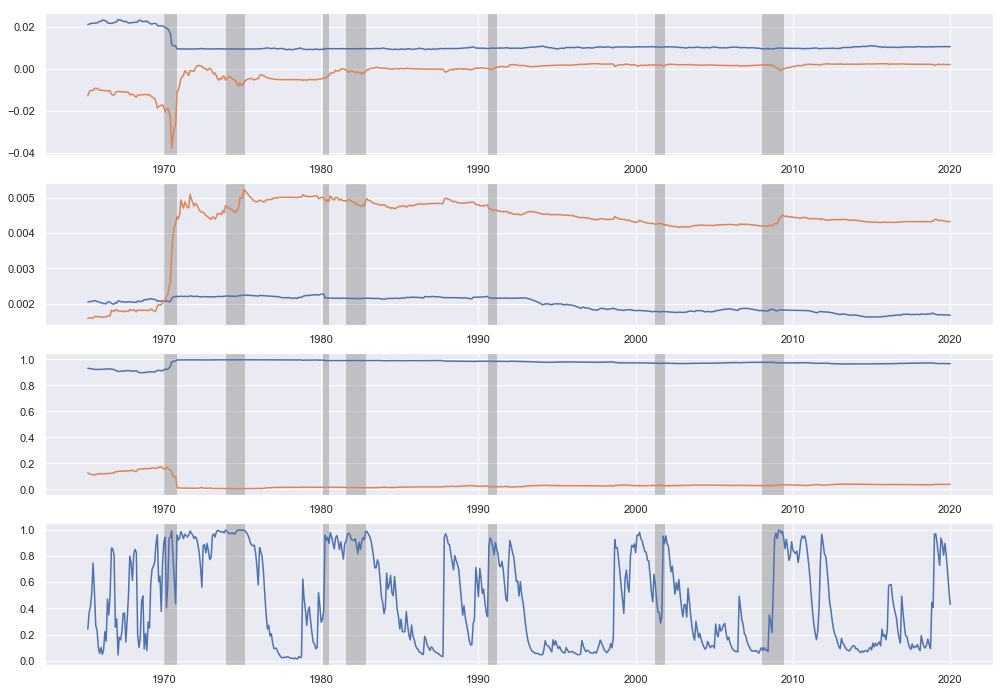

In [24]:
fix,axes = plt.subplots(4,1,figsize=[17,12])

ax = axes[0]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'mu_0'),(hmm_name,'mu_1')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[1]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'sigma2_0'),(hmm_name,'sigma2_1')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[2]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
d = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'p00'),(hmm_name,'p10')]]
d.index = d.index.get_level_values('Date')
ax.plot(d)

ax = axes[3]
plot.add_recession_bars(ax, startdate=df_xs_estimates.index.get_level_values('Date')[df_xs_estimates.index.get_level_values('Industry')==industry][240])
s = df_xs_estimates.loc[df_xs_estimates.index.get_level_values('Industry')==industry,(hmm_name,model_output.index)][[(hmm_name,'filt_prob_1')]]
s.index = s.index.get_level_values('Date')
ax.plot(s)

plt.show()